# CSD y CM de Actividad Evocada. 
Usemos esto como opurtunidad para poner todo el código en orden.


En este *notebook* de Julia implementaremos métodos numéricos para llevar a cabo un análisis de *centro de masa* (promedio vectorial) de la densidad de pozos y fuentes de corriente sobre una rebanada del hipocámpo de una rata. En este Notebook estudiaremos los datos de los experimentos evocados que hizo Franco en Agosto.
 Al parecer primero toca hacer una prueba con todo aquí mismo antes que hacer un modulo ordenado por una inconveniencia al hacer modulos (no se pueden recargar).

In [1]:
using HDF5

In [2]:
function AbreyCheca(x::AbstractString)
    #Abre el archivo de brw (acepta el nombre tal cual)
    archivo=h5open(x)
    #sacatito todas las variables que te interesan
    numcuadros=archivo["/3BRecInfo/3BRecVars/NRecFrames"][1][1]
    frecuencia=archivo["/3BRecInfo/3BRecVars/SamplingRate"][1][1]
    maxvolt=archivo["/3BRecInfo/3BRecVars/MaxVolt"][1][1]
    minvolt=archivo["/3BRecInfo/3BRecVars/MinVolt"][1][1]
    bitdepth=archivo["/3BRecInfo/3BRecVars/BitDepth"][1][1]
    duracionexperimento=numcuadros/frecuencia
    factordeescala=(maxvolt-minvolt)/2^bitdepth
    DatosCrudos=read(archivo["/3BData/Raw"])
    result=Dict("numcuadros" => numcuadros,
                "frecuencia"=> frecuencia,
                "maxvolt" => maxvolt,
                "minvolt" => minvolt,
                "bitdepth" => bitdepth,
                "duracion" => duracionexperimento,
                "factor" => factordeescala,
                "DatosCrudos"=>DatosCrudos )
    return result
                    
end

AbreyCheca (generic function with 1 method)

In [3]:
Datos=AbreyCheca("050815_3R7_converted.brw")

Dict{ASCIIString,Any} with 8 entries:
  "minvolt"     => -4125.0
  "maxvolt"     => 4125.0
  "frecuencia"  => 7020.800706028248
  "DatosCrudos" => 4096x210624 Array{UInt16,2}:…
  "bitdepth"    => 0x0c
  "factor"      => 2.01416015625
  "numcuadros"  => 210624
  "duracion"    => 29.99999698312937

In [5]:
function EncuentraTrancazosRaw(datos::Array, tolerancia=1400)
    result=Int[]
    longitud=length(datos)
    jcomp=0
    media=mean(datos)
    for j=1:longitud
        if abs(datos[j]-media)>tolerancia
            if j-jcomp>1
                push!(result,j)
            end
            jcomp=j
        end
    end
    return result
end


EncuentraTrancazosRaw (generic function with 2 methods)

In [6]:
exemplo=vec(Datos["DatosCrudos"][1500,:]);

In [7]:
using PyPlot
ion()

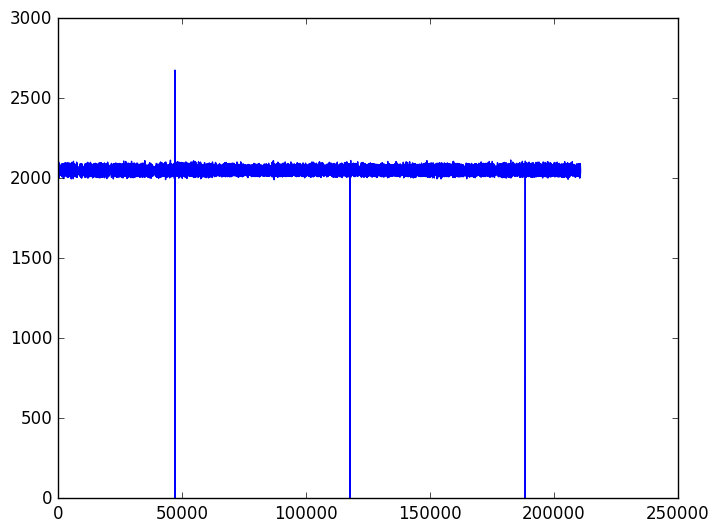

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7efe27e43908>

In [8]:
plot(1:210624,exemplo)

In [9]:
listongas=EncuentraTrancazosRaw(exemplo)

3-element Array{Int64,1}:
  47149
 117758
 188366

In [10]:
function ActivAlrededorTrancazo(Lista::Array, xxs::Array)
    #Aqui no se le ha hecho reshape a las matrices todavia
    result=Dict{AbstractString, Array}()
    q=1
    desde=36
    hasta=211
    for j in Lista
        nomineclave="Trancazo_$q"
        result[nomineclave]=xxs[:,j-desde:j+hasta]
        #println(nomineclave)
        q+=1
    end
    return result
end

function ActividadFueraTrancazo(Lista::Array, xxs::Array)
    q=1
    desde=36
    hasta=211
    aux=trues(xxs)
    for j in Lista
        aux[j-desde:j+hasta]=false
    end
    result=zeros(1)
    aux2=find(aux)
    for j in aux2
        result=vcat(result,xxs[j])
    end
    return result
end
        
    



ActividadFueraTrancazo (generic function with 1 method)

Rafael sugiere tomar $5ms$ antes del estímulo y unos $30ms$ después. En cuadros esto resulta ser unos 36 cuadros antes y 211 después.

In [11]:
ActividadRaw=ActivAlrededorTrancazo(listongas, Datos["DatosCrudos"])
(bla,tmax)=size(ActividadRaw["Trancazo_1"])

(4096,248)

In [12]:
factor=Datos["factor"]
function FormaMatrizDatosCentrados(xxs::Array)
    #El array tiene que ser de 4096 por algo mas
    irrrelevante,largo=size(xxs)
    aux=Array(Int32, 64,64, largo);
    for j=1:64,k=1:64
        aux[k,j,:]=xxs[j+(k-1)*64,:]
    end
    result=(aux*(-1)+2048)*factor;
    aux=0
    return result
end

FormaMatrizDatosCentrados (generic function with 1 method)

In [13]:
FueraTrancazo=ActividadFueraTrancazo(listongas,exemplo);
FueraTrancazo=(FueraTrancazo*(-1)+2048)*factor;


Hay un montonal de canales que por la forma en que requiere ser hecho el experimento no detectaron nada o casi nada. Esos aparecen el registro como saturados en el máximo valor posible. Dado que esto es MUY inconveniente para el cálculo del CM, tenemos que detectarlos automáticamente y ponerlos en cero o ver si los esquivamos.

In [14]:
DatosCentrados=Dict{AbstractString, Array}()
for k in keys(ActividadRaw)
    DatosCentrados[k]=FormaMatrizDatosCentrados(ActividadRaw[k])
end

In [125]:
function BuscaSaturados(datos::Array, saturavalue=1900)
    (ancho,alto,largo)=size(datos)
    result=Set{Array{Int,1}}()
    arreglostd=zeros(ancho,alto)
    arregloprom=zeros(ancho,alto)
    for j=1:ancho, k=1:alto
        prom=mean(datos[k,j,:])
        arregloprom[k,j]=prom
        desviacion=std(datos[k,j,:])
        arreglostd[k,j]=desviacion
        if abs(prom)>saturavalue # || desviacion<1
            push!(result, [k,j])
        end
    end
    return (result,arreglostd, arregloprom)
end

BuscaSaturados (generic function with 2 methods)

In [131]:
PruebSatu=BuscaSaturados(DatosCentrados["Trancazo_3"])
length(PruebSatu[1])
#in([1,1], PruebSatu[1])

123

In [132]:
DictSaturados=Dict{AbstractString, Tuple}()
for k in keys(DatosCentrados)
    DictSaturados[k]=BuscaSaturados(DatosCentrados[k])
end

In [95]:
#length(DictSaturados["Trancazo_3"][1])
#DictSaturados["Trancazo_3"][1]
#plot(vec(DatosCentrados["Trancazo_2"][1,1,:]))

In [96]:
function imitaruido(x::Array)
    #Esta funcion asume que x es ruido gaussiano y lo imita.
    #Igual de largo que xx
    sigma=std(x)
    prom=mean(x)
    l=length(x)
    result=sigma*randn(l)+prom
    return result
end

function hazruido(sigma, prom, length)
    # hace ruido
    result=round(Int32, sigma*randn(length)+prom)
    return result
end



hazruido (generic function with 1 method)

In [97]:
binsize=2
HistogramaRuido=hist(FueraTrancazo, -100:binsize:100)

(-100:2:100,[28,24,22,40,44,97,77,90,101,112  …  48,29,28,10,10,12,7,3,3,2])

In [98]:
sigmaruido=std(FueraTrancazo)
promruido=mean(FueraTrancazo)
(promruido,sigmaruido)

(-0.23790162174488164,28.013579915939754)

In [99]:
RuidoArtificial=imitaruido(FueraTrancazo)
HistoRuidoArtificial=hist(RuidoArtificial,-100:binsize:100)
norma=length(RuidoArtificial)
mean(RuidoArtificial),std(RuidoArtificial)


(-0.17216789854227593,28.0492812647304)

In [100]:
mu=promruido
sigma=sigmaruido
function gauss(x)
    return 1/(sqrt(2*pi)*sigma)*exp(-((x-mu)/sigma)^2/2)
end

gauss (generic function with 1 method)

In [101]:
xdata=collect(HistogramaRuido[1][2:end])
measuredata=HistogramaRuido[2];

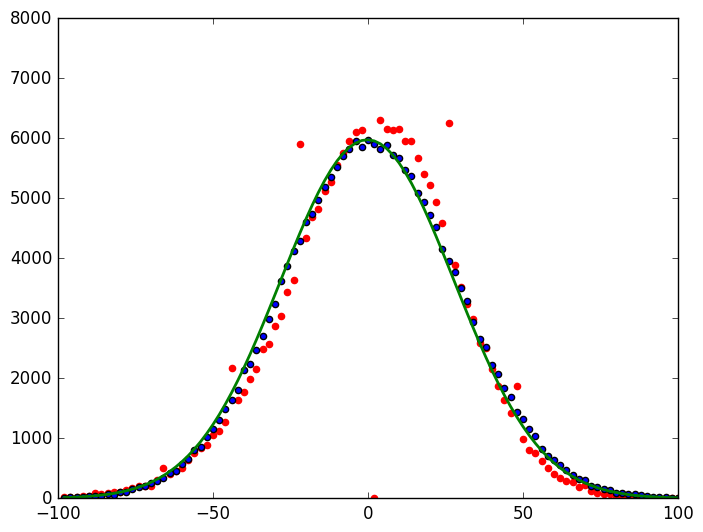

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7efe24720630>

In [102]:
figure(figsize=(8,6))
xlim(-100,100)
ylim(-0.1,8000)
scatter(xdata,measuredata, color="red")
scatter(HistoRuidoArtificial[1][2:end],HistoRuidoArtificial[2])
plot(xdata, map(x->binsize*norma*gauss(x),xdata), color="green",lw=2)
#savefig("GaussianasBonitas01.svg", dpi=96)

In [103]:
function vecindad8(punto::Array)
    j=punto[1]
    k=punto[2]
    result=Set{Array{Int64,1}}()
    push!(result, [j-1,k-1])
    push!(result, [j-1,k])
    push!(result, [j-1,k+1])
    push!(result, [j,k-1])
    push!(result, [j,k+1])
    push!(result, [j+1,k-1])
    push!(result, [j+1,k])
    push!(result, [j+1,k+1])
    return result
end

function promediasobreconjunto(puntos::Set, datos::Array)
    n=0
    result=0
    for q in puntos
        result+=datos[q[1],q[2]]
        n+=1
    end
    result/=n
    return result
end
        

promediasobreconjunto (generic function with 1 method)

In [133]:
DatosDesaturados=Dict{AbstractString, Array}()
n=0
l=0
for k in keys(DatosCentrados)
    largo=length(DatosCentrados[k][1,1,:])
    lista=DictSaturados[k][1]
    aux=copy(DatosCentrados[k])
   # println(k," ",length(lista))
    
     for m in lista
        conjuntoutil=setdiff(vecindad8(m),lista)
        q=m[1]
        p=m[2]
     #   if isempty(conjuntoutil)   
            aux[q,p,:]=hazruido(sigmaruido,promruido,largo)
            n+=1
     #   else
     #       for t=1:tmax
     #           aux[q,p,t]=promediasobreconjunto(conjuntoutil,aux[:,:,t])
     #       end
     #       l+=1
     #   end
     end
    DatosDesaturados[k]=aux
end
print(n,", ",l)

283, 0

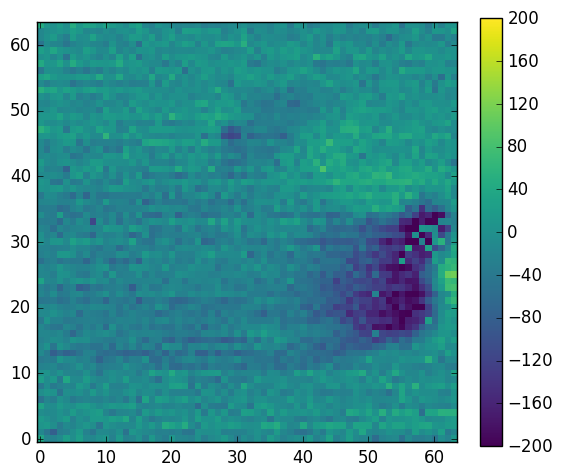

PyObject <matplotlib.colorbar.Colorbar object at 0x7efe240f3898>

In [136]:
ion()
limites=200
figure(figsize=(6,6))

exdesaturado=DatosDesaturados["Trancazo_2"][:,:,140];
imagen=imshow(exdesaturado, origin="lower", interpolation="nearest", cmap="viridis", vmin=-limites,vmax=limites)
cb=colorbar(imagen, fraction=0.046)
#savefig("LFP_Desaturado_1-340.svg", dpi=96)

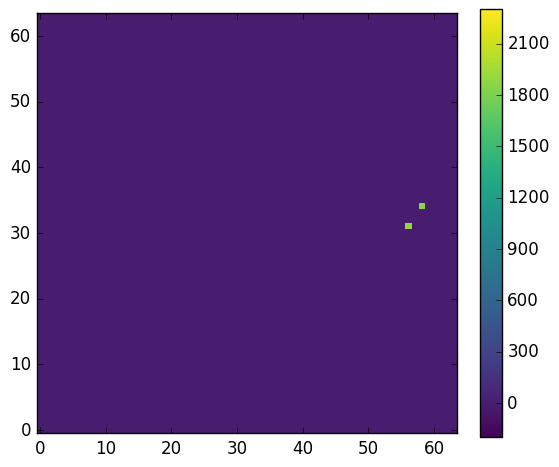

PyObject <matplotlib.colorbar.Colorbar object at 0x7efe261a8940>

In [138]:
limites=2300
figure(figsize=(6,6))
rara=zeros(64,64)
exdesaturado=mean!(rara, DatosDesaturados["Trancazo_2"]);
map!(x->x>1800?x:0, exdesaturado)
imagen=imshow(exdesaturado, origin="lower", interpolation="nearest", cmap="viridis", vmin=-200,vmax=limites)
cb=colorbar(imagen, fraction=0.046)

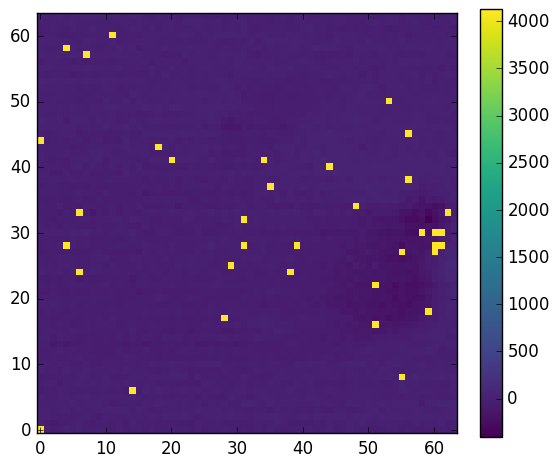

PyObject <matplotlib.colorbar.Colorbar object at 0x7efe23fc72e8>

In [106]:
figure(figsize=(6,6))
exsaturado=DatosCentrados["Trancazo_2"][:,:,140];
imagen=imshow(exsaturado, origin="lower", interpolation="nearest", cmap="viridis")
cb=colorbar(imagen,fraction=0.046)
#savefig("LFP_Saturado_1-340.svg", dpi=96)

In [148]:
PyPlot.ioff()
limites=200
for t=1:tmax 
    tau=t-36
    milisec=round(tau/7.02, 2)   
    exdesaturado=DatosDesaturados["Trancazo_2"][:,:,t];
    figure(figsize=(6,6))
    imagen=imshow(exdesaturado, origin="lower", interpolation="nearest", vmin=-limites,vmax=limites, cmap="jet")
    cb=colorbar(imagen, fraction=0.046)
    PyPlot.title("t= $milisec ms")
    
    savefig("LFP_Desaturado_2_3R7-$t.png", dpi=96)
    close()
end

In [149]:
function UnNormGauss(x,sigma)
    return exp(-x*x/(2*sigma))
end

function GaussSuavizarTemporal(Datos,Sigma=3)  
    #sigma esta medido en pixeles, es la desviacion estandar de nuestro kernel.
    #El medioancho de nuestra ventana seran 3*sigma
    #Esto es escencialmente un filtro pasabajos
    medioancho=ceil(Sigma*3)
    colchon=ones(medioancho)
    result=zeros(Datos)
    datoscolchon=vcat(colchon*Datos[1], Datos, colchon*Datos[end])
    kernel=map(x->UnNormGauss(x,Sigma), collect(-medioancho:medioancho))
    kernel=kernel/(sum(kernel))
    #La convolucion asi normalizada preserva el valor RELATIVO entre los puntos de la funcion.
    #pero queremos ponerlo mas parecido a los voltajes que medimos, para preservar el rango de valores
    #experimentales y su criterio de potenciales de accion / ruido
    for t=medioancho+1:length(Datos)-medioancho
        result[t-medioancho]=sum(datoscolchon[t-medioancho:t+medioancho].*kernel)
    end
    a=maximum(abs(Datos))
    b=maximum(abs(result))
    #nromalizacion 
    #result=result*a/b
    return result
end
    

GaussSuavizarTemporal (generic function with 2 methods)

In [150]:
#De momento todo "in file"
GaussianKernel=[0.00000067	0.00002292	0.00019117	0.00038771	0.00019117	0.00002292	0.00000067
0.00002292	0.00078634	0.00655965	0.01330373	0.00655965	0.00078633	0.00002292
0.00019117	0.00655965	0.05472157	0.11098164	0.05472157	0.00655965	0.00019117
0.00038771	0.01330373	0.11098164	0.22508352	0.11098164	0.01330373	0.00038771
0.00019117	0.00655965	0.05472157	0.11098164	0.05472157	0.00655965	0.00019117
0.00002292	0.00078633	0.00655965	0.01330373	0.00655965	0.00078633	0.00002292
    0.00000067	0.00002292	0.00019117	0.00038771	0.00019117	0.00002292	0.00000067]

function GaussianSmooth(Datos)
    tamanodatos=size(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    for j=1:3
        temp=vcat(temp[1,:], temp, temp[end,:])
    end
    for j=1:3
        temp=hcat(temp[:,1], temp, temp[:,1])
    end
    
    for j=4:tamanodatos[1]+3, k=4:tamanodatos[2]+3
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-3:j+3,k-3:k+3]
        result[j-3,k-3]=sum(GaussianKernel.*aux)
    end
    #Esta convolución no respeta norma L2
    #result=result*maximum(abs(Datos))/maximum(abs(result))
    return result
end



GaussianSmooth (generic function with 1 method)

In [151]:
#checa que Julia va ordenando los datos renglon por renglon, no columna por columna
LaplacianTerm1=[[0 1 0]; [1 -4 1]; [0 1 0]]
LaplacianTerm2=[[0.5 0 0.5]; [0 -2 0]; [0.5 0 0.5]]
LaplacianKernel=(1-1/3)*LaplacianTerm1+(1/3)*LaplacianTerm2

#Nueva variante: AHORA SI VAMOS A ELIMINAR LAS ORILLAS
#Los efectos de borde estan dando puro choro en el CSD.
function DiscreteLaplacian(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    temp=vcat(temp[1,:], temp, temp[end,:])
    temp=hcat(temp[:,1], temp, temp[:,end])
    largo,ancho=size(Datos)
    aux=Array(Float64,(3,3))
    result=zeros(Datos)
    for j=2:largo+1, k=2:ancho+1
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-1:j+1,k-1:k+1]
        result[j-1,k-1]=sum(LaplacianKernel.*aux)
    end
    #Crop the borders
    result=result[2:end-1,2:end-1]
    return result
end

DiscreteLaplacian (generic function with 1 method)

In [152]:
CSD=Dict{AbstractString, Array}()
for k in keys(DatosDesaturados)
    (mu,nu,lu)=size(DatosDesaturados[k])
    aux1=zeros(mu,nu,lu)
    aux2=zeros(mu-2,nu-2,lu)
    temp=map(Float64,DatosDesaturados[k])
    for t=1:lu
        aux1[:,:,t]=GaussianSmooth(temp[:,:,t])
        aux2[:,:,t]=DiscreteLaplacian(aux1[:,:,t])
    end
    CSD[k]=-aux2
end

In [153]:
CSDPlanchada=Dict{AbstractString, Array}()
for k in keys(CSD)
    (mu,nu,lu)=size(CSD[k])
    aux=zeros(mu,nu,lu)
    for j=1:mu,l=1:nu
        porromponpon=vec(CSD[k][j,l,:])
        aux[j,l,:]=GaussSuavizarTemporal(porromponpon)
    end
    CSDPlanchada[k]=aux
end

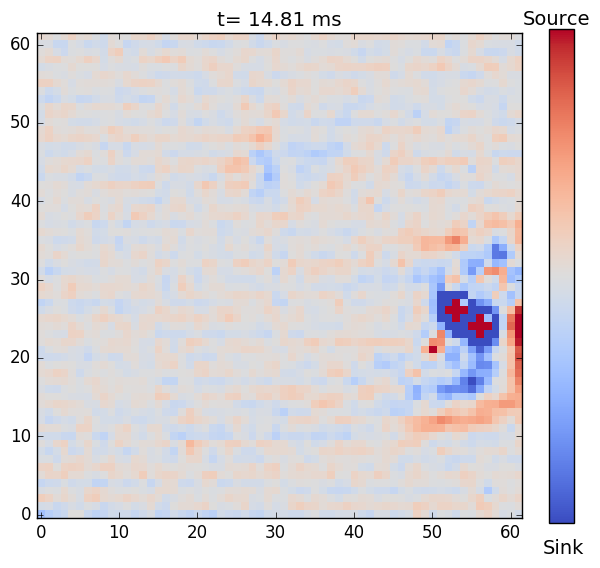

In [144]:
ion()
t=140
tau=t-36
milisec=round(tau/7.02, 2)
CSDexample=CSDPromedio[:,:,t];

figure(figsize=(6,6))
#exsaturado=DatosCentrados["Trancazo_1"][:,:,340]+DatosCentrados["Trancazo_3"][:,:,340]+DatosCentrados["Trancazo_2"][:,:,340]
imagen=imshow(CSDexample, origin="lower", interpolation="nearest", cmap="coolwarm", vmin=-40, vmax=40)
cb=colorbar(imagen,fraction=0.046, ticks=[])
 PyPlot.title("t= $milisec ms")

   
    annotate("Source",
    xy=[1.03;0.98],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
#font_properties=("DejaVu Serif"),
    fontsize=14,
    ha="left",
   va="bottom")


annotate("Sink",
    xy=[1.07;-0.11],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
    fontsize=14.0,
    ha="left",
    va="bottom")
    
tight_layout()  
#savefig("CSDSuave_1-$t.png", dpi=96)


In [156]:

PyPlot.ioff()
for t=1:tmax
    tau=t-36
    milisec=round(tau/7.02, 2)
    
    datos=CSDPlanchada["Trancazo_2"][:,:,t];
    figure(figsize=(6,6))
    imagen=imshow(datos, origin="lower", interpolation="nearest", vmin=-60,vmax=60, cmap="coolwarm")
    cb=colorbar(imagen, fraction=0.046, ticks=[])
    PyPlot.title("t= $milisec ms")
    
    annotate("Source",
    xy=[1.03;0.98],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
#font_properties=("DejaVu Serif"),
    fontsize=14,
    ha="left",
   va="bottom")


annotate("Sink",
    xy=[1.07;-0.11],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
    fontsize=14.0,
    ha="left",
    va="bottom")
    
    tight_layout()    
    savefig("CSDPlanchado_2_3R7-$t.png", dpi=96)
    close()
end

In [145]:
using JLD
save("CSDEvocada.jld", "CSDPlanchada", CSDPlanchada, "CSD", CSD)

In [143]:
CSDPromedio=CSDPlanchada["Trancazo_1"]+CSDPlanchada["Trancazo_2"]+CSDPlanchada["Trancazo_3"];
CSDPromedio/=3.0;

In [ ]:
PyPlot.ioff()
for t=1:501
    datos=CSDPromedio[:,:,t];
    figure(figsize=(6,6))
    imagen=imshow(datos, origin="lower", interpolation="nearest", vmin=-20,vmax=20, cmap="coolwarm")
    cb=colorbar(imagen, fraction=0.046)
    savefig("CSD_Promedio-$t.png", dpi=96)
    close()
end


In [157]:
function ObtenComponentesYEscribe(Datos::Array, tini=1, tfini=tmax, epsilon=1.0)
    #CSD ahora no tiene orillas. Asi que toca adaptarse.
    
    
 for t=tini:tfini
    #iniciar variables vacias
    ActividadNegativa=Array{Int16}[]
    ActividadPositiva=Array{Int16}[]
    SpikeCountPositivo=zeros(62,62)
    SpikeCountNegativo=zeros(62,62)
    #Todos
    for j=1:62, k=1:62
            if(Datos[j,k,t]<-epsilon)     
            push!(ActividadNegativa, [j, k])
            SpikeCountNegativo[j,k]+=1
                elseif(Datos[j,k,t]>epsilon)
            push!(ActividadPositiva, [j, k])
            SpikeCountPositivo[j,k]+=1
        end             
    end

    #Simple pass method
    listaneg=copy(ActividadNegativa)
    listapos=copy(ActividadPositiva)
    componentesneg=Set{Any}()
    componentespos=Set{Any}()
    #Primero lo negativo (pozos)
    while(length(listaneg)!=0)
        x=pop!(listaneg) #arranca el ULTIMO elemento de la lista
        listaprofundeza=Array{Int64}[]
        componentecurlab=Array{Int64}[]
        push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
        push!(componentecurlab, x)    
        profundidad=0
        while ((length(listaprofundeza)!=0) && profundidad<1000)
            y=pop!(listaprofundeza)
            for v in vecindad8(y)
                if in(v, listaneg)
             #   
                        deleteat!(listaneg, indexin(Any[v], listaneg))
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                end
            end
        end
    # println("Para ", x, "la profundidad fue ", profundidad)
        
        push!(componentesneg, componentecurlab)
    end


    centrosdemasaneg=[[0 0 0];]
    for p in componentesneg
        masa=0.00
        x=0.00
        y=0.00
        for q in p
            j=q[1]
            k=q[2]
                masalocal=Datos[j,k,t]
            masa+=masalocal
            x+=k*masalocal
            y+=j*masalocal
        end
        x/=masa
        y/=masa
        A=[x y masa]
        centrosdemasaneg=vcat(centrosdemasaneg, A)
    end
    centrosdemasaneg=centrosdemasaneg[2:end,:]
        zacatlan="CenterOfMassCollector/CMPozos-$t.dat"
    writedlm(zacatlan, centrosdemasaneg)
    ##### Ahora lo posittivo (fuentes)
    while(length(listapos)!=0)
        x=pop!(listapos) #arranca el ULTIMO elemento de la lista
        listaprofundeza=Array{Int64}[]
        componentecurlab=Array{Int64}[]
        push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
        push!(componentecurlab, x)    
        profundidad=0
        while ((length(listaprofundeza)!=0) && profundidad<1000)
            y=pop!(listaprofundeza)
            for v in vecindad8(y)
                if in(v, listapos)
             #   
                        deleteat!(listapos, indexin(Any[v], listapos))
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                end
            end
        end
    # println("Para ", x, "la profundidad fue ", profundidad)
        
        push!(componentespos, componentecurlab)
    end


    centrosdemasapos=[[0 0 0];]
    for p in componentespos
        masa=0.00
        x=0.00
        y=0.00
        for q in p
            j=q[1]
            k=q[2]
                masalocal=Datos[j,k,t]
            masa+=masalocal
            x+=k*masalocal
            y+=j*masalocal
        end
        x/=masa
        y/=masa
        A=[x y masa]
        centrosdemasapos=vcat(centrosdemasapos, A)
    end
    centrosdemasapos=centrosdemasapos[2:end,:]
        zacatlan="CenterOfMassCollector/CMFuentes-$t.dat"
    writedlm(zacatlan, centrosdemasapos)
end
    return 0
end

ObtenComponentesYEscribe (generic function with 4 methods)

In [ ]:
ObtenComponentesYEscribe(CSDPlanchada["Trancazo_2"], 1,tmax,1)

In [ ]:
function leeunmegaarray(NomineGeneralis::AbstractString, cuantos=501)
    LeMegaArray=Array[]
    for t=35:cuantos
      #  println("$NomineGeneralis-$t.dat")
        CMx=readdlm("$NomineGeneralis-$t.dat")
        push!(LeMegaArray, CMx)
    end
    return LeMegaArray
end

In [ ]:
function dist2D(x::Array,y::Array)
    result=sqrt((x[1]-y[1])^2+(x[2]-y[2])^2)
    return result
end

In [ ]:
function encuentraTrayectorias(Datos::Array, mincadena=20)

toleradist=4.0*sqrt(2)
tau=1
t=1
j=1
Catenario=Set{Array{Any}}()
Cadena=[0 0 0 0]
    CopiaMegaArray=deepcopy(Datos);
    NumFrames=length(Datos)
FakeNumFrames=NumFrames



while t <= FakeNumFrames-1 
    
    tau=t
    
    @label arrrrh
  
    jmax,nada= size(CopiaMegaArray[tau])
    
    while j <=jmax && tau<FakeNumFrames
        
            if abs(CopiaMegaArray[tau][j,3]) > 0.05
                       
            Eslabon=[copy(CopiaMegaArray[tau][j,:]) tau]
            Cadena=vcat(Cadena, Eslabon)
         #   println("Papa t: ", t, "  tau: ", tau, " y  j: ",j )
            mindist=2
            kasterisco=1
            kmax, nada= size(CopiaMegaArray[tau+1])
            huboalgo=false
          
        #    kmax=5
            
            for k=1:kmax
                
                EslabonTentativo=CopiaMegaArray[tau+1][k,:]
            #    println(EslabonTentativo)
                    if abs(EslabonTentativo[3])>0.05
                    dist=dist2D(Eslabon,EslabonTentativo)                  
                    if dist<mindist
                        mindist=dist
                        kasterisco=k
                        
                       # println(kasterisco, "=k*", k, "=k")
                        huboalgo=true
                    end
                end
            
            end    
            
            if huboalgo && mindist<toleradist
                #quitamos el anterior
                CopiaMegaArray[tau][j,3]=0.0000 
               # println(mindist," ", t, " ", tau+1 ," ", kasterisco )
                
                if tau+1<FakeNumFrames
                    tau+=1
                    j=kasterisco
      #              println("Pepe t: ", t, "  tau: ", tau, " y  j: ",j )
                    @goto arrrrh
                
                else
                    
                    Eslabon=[copy(CopiaMegaArray[tau+1][kasterisco,:]) tau+1]
                    Cadena=vcat(Cadena, Eslabon)
      #              println("Pipi t: ", t, "  t: ", t, " y  j: ",j )
                    j+=1
                    tau=t
                    
                    if size(Cadena)[1]>mincadena
                        push!(Catenario, Cadena[2:end,:])
                    end
                    
                    Cadena=[0 0 0 0]
                    @goto arrrrh
                end
                                
            else
                
                if size(Cadena)[1]>mincadena
                    push!(Catenario, Cadena[2:end,:])
                end
                Cadena=[0 0 0 0]
                j+=1
                tau=t
                @goto arrrrh
            end
                       
        end #cierra sobre el if de  la masa 
                
        j+=1                    
        tau=t
    
    end
    @label urrr
      
    j=1
    t+=1
    tau=t
    Cadena=[0 0 0 0]
end 
    
    return Catenario
end

In [ ]:
MegaArrayPositivo=Array[]
MegaArrayNegativo=Array[]
MegaArrayPositivo=leeunmegaarray("CenterOfMassCollector/CMFuentes",480);
MegaArrayNegativo=leeunmegaarray("CenterOfMassCollector/CMPozos",480);

In [ ]:

CatenarioPositivo=encuentraTrayectorias(MegaArrayPositivo, 2);
CatenarioNegativo=encuentraTrayectorias(MegaArrayNegativo,2);

In [ ]:
save("Catenarios4AP-Trancazo-3.jld", "CatenarioNegativo", CatenarioNegativo, "CatenarioPositivo", CatenarioPositivo)

In [ ]:
CatenarioPositivo=load("Catenarios4AP-01.jld", "CatenarioPositivo")
CatenarioNegativo=load("Catenarios4AP-01.jld", "CatenarioNegativo");

In [ ]:
ImagenCSD=CSDPlanchada["Trancazo_1"][:,:,64];

In [ ]:
ion()

figure(figsize=(6,6))
#axis("equal")
tick_params(labelbottom="off", labelleft="off")
xlim(-0.50,61.5)
ylim(-0.5,61.5)
bolitasrojas=0
bolitasazules=0
minlargo=5
marcagor=85
muevemin=0.5
tight_layout()

guacafondo=imshow(ImagenCSD, cmap="bwr", interpolation="spline16", origin="lower", vmin=-40, vmax=40)

for p in CatenarioPositivo
    gordura=abs(map(Float32,p[:,3]))
    desviax=std(map(Float32,p[:,1]))
    desviay=std(map(Float32,p[:,2]))
    longus,falsus=size(p)
    if mean(gordura)> marcagor && (desviax>muevemin || desviay>muevemin) && longus> minlargo 
        #Si son chiquitos no nos interesan.
        xxpos=p[:,1]
        yypos=p[:,2]    
        tiempos=p[:,4]/7022    
        plot(xxpos, yypos, marker="o", markersize=1, color="r")
        #bolitasrojas=scatter(xxpos,yypos, s=gordura, 
        #edgecolors="none", color="r" )
        inicios=scatter(xxpos[1],yypos[1], s=marcagor, edgecolors="black", 
        linewidth=1,
        facecolor="red", marker="o" )
        finales=scatter(xxpos[end],yypos[end], s=marcagor, edgecolors="black", 
        linewidth=1,facecolor="red", marker="^", label="Final" )
      #  annotate(round(tiempos[1]*1000,1),  (xxpos[1], yypos[1]), fontsize=7, color="black")
       # annotate(round(tiempos[end]*1000,1), (xxpos[end], yypos[end]), fontsize=7, color="green")

    end
end




for p in CatenarioNegativo
    gordura=abs(map(Float32,p[:,3]))
    desviax=std(map(Float32,p[:,1]))
    desviay=std(map(Float32, p[:,2]))
    longus,falsus=size(p)
    if mean(gordura)>marcagor && (desviax>muevemin || desviay > muevemin) &&longus> minlargo
        #Si son chiquitos no nos interesan.
        xxpos=p[:,1]
        yypos=p[:,2]    
        tiempos=p[:,4]/7022    
        plot(xxpos, yypos, marker="o", markersize=1, color="b")
        #bolitasazules=scatter(xxpos,yypos, s=gordura,
        #edgecolors="none", color="b")
        inicios=scatter(xxpos[1],yypos[1], s=marcagor, edgecolors="black", 
        linewidth=1,
        facecolor="blue", alpha=0.7, marker="o", label="Final" )
        finales=scatter(xxpos[end],yypos[end], s=marcagor, edgecolors="black", 
        linewidth=1,
        facecolor="blue", marker="^", label="Final" )
      #  annotate(round(tiempos[1],4),  (xxpos[1], yypos[1]), fontsize=7, color="black")
      #  annotate(round(tiempos[end],4), (xxpos[end], yypos[end]), fontsize=7, color="green")

    end
end

#colorbar(bolitasrojas, fraction=0.046)
#colorbar(bolitasazules, fraction=0.052, ticks=[])

savefig("TrayectoriaEvocada_1R4_Trancazo-1.svg", dpi=90)